<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 5 - NLP - Skip-Gram <br>
<font color=0CBCDF size=4>
   &#x1F335; Amirhossein Akbari  &#x1F335;
</div>

____

<font color=9999FF size=4>
&#x1F388; Full Name : Amir Mohammad Mahfoozi
<br>
<font color=9999FF size=4>
&#x1F388; Student Number : 401106469

<font color=0080FF size=3>
This notebook explores word embeddings, compact and dense vector representations of words that capture their textual meaning. This notebook focusing on implementing the Word2Vec algorithm using the Skip-gram architecture and negative sampling.
</font>
<br>

**Note:**
<br>
<font color=66B2FF size=2>In this notebook, you are free to use any function or model from TensorFlow to assist with the implementation. However, PyTorch is not permitted for this exercise. This ensures consistency and alignment with the tools being focused on.</font>
<br>
<font color=red size=3>**Run All Cells Before Submission**</font>: <font color=FF99CC size=2>Before saving and submitting your notebook, please ensure you run all cells from start to finish. This practice guarantees that your notebook is self-consistent and can be evaluated correctly by others.</font>

<font color=#ffb578 size=3>
you are free to modify, add, or remove any cells as you see fit to complete your tasks. Feel free to change any of the provided code or content to better suit your understanding and approach to the problems.

- **Questions**: If you have any questions or require clarifications as you work through the notebook, please do not hesitate to ask. You can post your queries on Quera or reach out via Telegram.
- **Feedback**: We encourage you to seek feedback and engage in discussions to enhance your learning experience and improve your solutions.
</font>

In [2]:
import io
import math
import gzip
# !pip install nltk
import nltk
import time
import random
import numpy as np
import tensorflow as tf
# !pip install gensim
import gensim.downloader as api
# !pip install tensorflow-datasets
import tensorflow_datasets as tfds
nltk.download('stopwords')

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import nltk
from nltk.corpus import stopwords

try:
    stopwords.words('english')
    print("Stopwords are available!")
except LookupError:
    print("Stopwords not found.")


Stopwords are available!


### Downloading Dataset
We're going to use text8 dataset. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes.

In [4]:
def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

[==================================================] 100.0% 31.6/31.6MB downloaded


In [5]:
print(wiki[0:200])
print(len(wiki))

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term 
100000000


### Preprocessing data

**Stopwords removal** - Begin by removing stopwords from the dataset, as they provide little to no value in learning word embeddings. Ensure your preprocessing pipeline filters out commonly used words such as "the," "and," or "of" that do not contribute to meaningful semantic relationships.

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

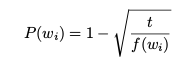

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

Implement a subsampling mechanism to handle overly frequent words in the corpus. Use the heuristic formula provided by Mikolov et al. to calculate the probability of dropping a word based on its frequency. This step ensures the corpus maintains a balance between rare and frequent words, improving the quality of word co-occurrence relationships.

---

**Filtering words** - Filter out words that occur only once in the dataset, as they lack sufficient context to be represented effectively. Retain only those words that appear at least five times in the corpus to minimize noise and enhance the overall quality of the embeddings.


In [6]:
import random
from collections import Counter
from nltk.corpus import stopwords

def replace_punctuation(text):
    replacements = {
        '.': ' <dot> ', ',': ' <comma> ', '!': ' <exclamation> ',
        '?': ' <question> ', ':': ' <colon> ', ';': ' <semicolon> '
    }
    for char, token in replacements.items():
        text = text.replace(char, token)
    return text

def clean_text(text):
    return text.lower().strip()

def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

def filter_low_frequency(words, min_frequency=5):
    word_counts = Counter(words)
    return [word for word in words if word_counts[word] >= min_frequency], word_counts

def subsample_word(word, word_counts, total_word_count, threshold=1e-5):
    freq = word_counts[word] / total_word_count
    return 1 - (threshold / freq)**0.5 if freq > threshold else 0

def subsample_words(words, word_counts):
    total_word_count = sum(word_counts.values())
    return [word for word in words if random.random() > subsample_word(word, word_counts, total_word_count)]

def preprocess_text(text):
    text = replace_punctuation(text)
    text = clean_text(text)
    words = text.split()
    words = remove_stopwords(words)
    words, word_counts = filter_low_frequency(words)
    words = subsample_words(words, word_counts)
    return words, Counter(words)


In [7]:
preprocessed_words, word_counts = preprocess_text(wiki)
sample = preprocessed_words[1500:1550]
print(sample)

['interests', 'petite', 'bourgeoisie', 'plekhanov', 'marxist', 'critique', 'nine', 'characterised', 'middle', 'capitalist', 'protesters', 'tacit', 'authoritarianism', 'criticised', 'preserving', 'tacitly', 'statist', 'authoritarian', 'bureaucratic', 'tendencies', 'behind', 'dogmatic', 'facade', 'hypocrisy', 'critics', 'sexist', 'racist', 'anarchists', 'notably', 'proudhon', 'bakunin', 'hypocrisy', 'inherent', 'anarchists', 'dismiss', 'prejudices', 'theorists', 'beliefs', 'anarchists', 'criticise', 'anarchism', 'impact', 'proudhon', 'fascism', 'groups', 'cercle', 'proudhon', 'anarcho', 'capitalist', 'bryan']


It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings.



In [8]:
EMBEDDING_DIM = 128      
BUFFER_SIZE = 1000        
BATCH_SIZE = 512        
EPOCHS = 4

### Preparing TensorFlow Dataset using Skipgrams

**Generating Skipgrams**

Tokenize your preprocessed textual data and convert the words into their corresponding vectorized tokens. Then, use the `skipgrams` function provided by Keras to generate (word, context) pairs. Ensure the following steps are completed:

- Generate positive samples: (word, word in the same window), with label 1.  
- Generate negative samples: (word, random word from the vocabulary), with label 0.  

Refer to Mikolov et al.'s paper, [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf), for more details on Skipgrams.

---

**Negative Sampling**

For each input word, implement the negative sampling approach to optimize the training process. Transform the problem of predicting context words into independent binary classification tasks. For every (target, context) pair, generate random negative (target, ~context) samples. This step will reduce computational complexity and make training more efficient.


In [9]:
# !pip install scikit-learn
from sklearn.model_selection import train_test_split
def initialize_tokenizer(preprocessed_words):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(preprocessed_words)
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    vectorized_words = tokenizer.texts_to_sequences([preprocessed_words])[0]
    return tokenizer, word_index, vocab_size, vectorized_words

def generate_skipgram_pairs(vectorized_words, vocab_size, subset_size=300000):
    vectorized_subset = vectorized_words[:subset_size]
    skipgram_pairs, labels = skipgrams(
        vectorized_subset, vocabulary_size=vocab_size, window_size=5, negative_samples=5, seed = 42
    )
    targets, contexts = zip(*skipgram_pairs)
    targets = tf.constant(targets, dtype=tf.int32)
    contexts = tf.constant(contexts, dtype=tf.int32)
    labels = tf.constant(labels, dtype=tf.float32)
    return targets, contexts, labels

def split_data(targets, contexts, labels, test_ratio=0.2):
    return train_test_split(
        targets.numpy(), contexts.numpy(), labels.numpy(), test_size=test_ratio, random_state=42
    )

def create_dataset(targets, contexts, labels, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
    return dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)


tokenizer, word_index, vocab_size, vectorized_words = initialize_tokenizer(preprocessed_words)
targets, contexts, labels = generate_skipgram_pairs(vectorized_words, vocab_size)
train_targets, test_targets, train_contexts, test_contexts, train_labels, test_labels = split_data(targets, contexts, labels)
train_dataset = create_dataset(train_targets, train_contexts, train_labels, BATCH_SIZE, BUFFER_SIZE)
test_dataset = create_dataset(test_targets, test_contexts, test_labels, BATCH_SIZE, BUFFER_SIZE)

train_size = tf.data.experimental.cardinality(train_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

print("training dataset:")
print(train_size)
print("Number of batches in the testing dataset")
print(test_size)

training dataset:
28125
Number of batches in the testing dataset
7032


### Building the Model

Use the model subclassing method to build your model. While Sequential and Functional APIs are generally more suitable for most use cases, model subclassing allows you to create the model in an object-oriented way. Follow these steps:

1. Define a custom model class by inheriting from `tf.keras.Model`.
2. Implement the `__init__` method to define the layers of your model.
3. Override the `call` method to define the forward pass of your model.
4. Ensure that the model includes embedding layers, a skip-gram architecture, and any other necessary components for training.


In [10]:
import tensorflow as tf
from tensorflow.keras import layers

class SkipGramModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.target_embedding = self.create_embedding_layer(vocab_size, embedding_dim, "target_embedding")
        self.context_embedding = self.create_embedding_layer(vocab_size, embedding_dim, "context_embedding")
        self.dots = layers.Dot(axes=1)

    @staticmethod
    def create_embedding_layer(vocab_size, embedding_dim, name):
        return layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            embeddings_initializer='glorot_uniform',
            name=name
        )

    def call(self, inputs):
        target, context = inputs
        target_emb, context_emb = self.get_embeddings(target, context)
        return tf.squeeze(self.compute_dot_product(target_emb, context_emb), axis=1)

    def get_embeddings(self, target, context):
        return self.target_embedding(target), self.context_embedding(context)

    def compute_dot_product(self, target_emb, context_emb):
        return self.dots([target_emb, context_emb])


skipgram_model = SkipGramModel(vocab_size, EMBEDDING_DIM)
dummy_target = tf.constant([1, 2, 3])
dummy_context = tf.constant([4, 5, 6]) 
_ = skipgram_model((dummy_target, dummy_context))

skipgram_model.summary()

Model: "skip_gram_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ target_embedding (Embedding)         │ (3, 128)                    │       9,106,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ context_embedding (Embedding)        │ (3, 128)                    │       9,106,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dot (Dot)                            │ (3, 1)                      │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,212,096 (69.47 MB)

 Trainable params: 18,212,096 (69.47 MB)

 Non-trainable params: 0 (0.00 B)

### Loss function, Metrics and Optimizers

In [11]:
def initialize_optimizer():
    return tf.keras.optimizers.Adam()

def initialize_loss_function():
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)

def initialize_metrics():
    return tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.BinaryAccuracy()

def create_word2vec_model(vocab_size, embedding_dim):
    return SkipGramModel(vocab_size, embedding_dim)

def setup_training_environment(vocab_size, embedding_dim):
    optimizer = initialize_optimizer()
    loss_fn = initialize_loss_function()
    train_acc_metric, val_acc_metric = initialize_metrics()
    model = create_word2vec_model(vocab_size, embedding_dim)
    return model, optimizer, loss_fn, train_acc_metric, val_acc_metric

model, optimizer, loss_fn, train_acc_metric, val_acc_metric = setup_training_environment(vocab_size, EMBEDDING_DIM)


### Training the Model

Implement custom training for learning word embeddings to gain finer control over optimization and training tasks. Follow these steps:

1. Define a custom training loop that includes forward propagation, loss computation, and backpropagation.
2. Use the optimizer of your choice to update the model's weights based on the computed gradients.
3. Implement batching for efficient data processing during training.
4. Monitor the loss during each epoch to track the model's performance.
5. Save the trained embeddings for later use once the training is complete.

In [12]:
import time

@tf.function
def train_step(targets, contexts, labels, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        predictions = model((targets, contexts))
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def test_step(targets, contexts, labels, model, loss_fn, val_acc_metric):
    predictions = model((targets, contexts))
    loss = loss_fn(labels, predictions)
    val_acc_metric.update_state(labels, predictions)
    return loss

def initialize_checkpoint(optimizer, model):
    return tf.train.Checkpoint(optimizer=optimizer, model=model)

def run_training_epoch(train_dataset, model, optimizer, loss_fn, train_acc_metric):
    total_train_loss = 0.0
    train_acc_metric.reset_state()
    total_batches = tf.data.experimental.cardinality(train_dataset).numpy()
    print(f"Total number of batches in the training dataset: {total_batches}")
    
    for batch, ((targets, contexts), labels) in enumerate(train_dataset):
        loss = train_step(targets, contexts, labels, model, optimizer, loss_fn, train_acc_metric)
        total_train_loss += loss
    print(total_train_loss)
    return total_train_loss

def run_validation_epoch(test_dataset, model, loss_fn, val_acc_metric):
    total_val_loss = 0.0
    val_acc_metric.reset_state()
    total_batches = tf.data.experimental.cardinality(test_dataset).numpy()
    print(f"Total number of batches in the test dataset: {total_batches}")
    for batch, ((targets, contexts), labels) in enumerate(test_dataset):
        val_loss = test_step(targets, contexts, labels, model, loss_fn, val_acc_metric)
        total_val_loss += val_loss

    print(total_val_loss)
    return total_val_loss

def train_model(model, train_dataset, test_dataset, optimizer, loss_fn, train_acc_metric, val_acc_metric, epochs=5):
    checkpoint = initialize_checkpoint(optimizer, model)
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}')
        start_time = time.time()

        total_train_loss = run_training_epoch(train_dataset, model, optimizer, loss_fn, train_acc_metric)
        total_val_loss = run_validation_epoch(test_dataset, model, loss_fn, val_acc_metric)

        train_acc = train_acc_metric.result()
        val_acc = val_acc_metric.result()
        end_time = time.time()

        print(f'Training Loss: {total_train_loss.numpy()}, Validation Loss: {total_val_loss.numpy()}')
        print(f'Training Accuracy: {train_acc.numpy()}, Validation Accuracy: {val_acc.numpy()}')
        print(f'Time taken for epoch {epoch + 1}: {end_time - start_time:.2f} seconds')
    checkpoint.save(file_prefix="./model")

# !nvcc --version
# !pip list | grep tensorflow
# !pip uninstall tensorflow
# !pip install tensorflow-gpu
# !ls /usr/local/cuda/lib64 | grep cudnn

train_model(model, train_dataset, test_dataset, optimizer, loss_fn, train_acc_metric, val_acc_metric)


Epoch 1
Total number of batches in the training dataset: 28125
tf.Tensor(9547.981, shape=(), dtype=float32)
Total number of batches in the test dataset: 7032
tf.Tensor(1993.8778, shape=(), dtype=float32)
Training Loss: 9547.9814453125, Validation Loss: 1993.8778076171875
Training Accuracy: 0.8609985113143921, Validation Accuracy: 0.8756870627403259
Time taken for epoch 1: 284.85 seconds
Epoch 2
Total number of batches in the training dataset: 28125
tf.Tensor(6239.382, shape=(), dtype=float32)
Total number of batches in the test dataset: 7032
tf.Tensor(1707.0592, shape=(), dtype=float32)
Training Loss: 6239.3818359375, Validation Loss: 1707.0592041015625
Training Accuracy: 0.9031744599342346, Validation Accuracy: 0.8960633873939514
Time taken for epoch 2: 282.69 seconds
Epoch 3
Total number of batches in the training dataset: 28125
tf.Tensor(3834.1074, shape=(), dtype=float32)
Total number of batches in the test dataset: 7032
tf.Tensor(1677.1873, shape=(), dtype=float32)
Training Loss: 

### Word Embeddings Projector

Follow these steps to visualize the learned word embeddings using TensorFlow's Embedding Projector:

1. Extract the weights of the embedding layer from your trained model.
2. Save the weights into two files:
   - `vecs.tsv`: This file will store the actual vector representations of words.
   - `meta.tsv`: This file will store the associated metadata (e.g., word labels) for visualization.
3. Go to [TensorFlow Embedding Projector](http://projector.tensorflow.org/).
4. Upload the `vecs.tsv` and `meta.tsv` files created in the previous step.
5. Explore the visualizations provided by TensorFlow's Embedding Projector.
<font color=#ffb578>
6.Save the visualization of a word that best demonstrate the quality of your embeddings as an image and store it near the notebook.
7. Compress the folder into a `.zip` file and submit it as part of your work.

</font>


In [13]:
embedding_layer = model.target_embedding
embeddings = embedding_layer.get_weights()[0]
import numpy as np
np.savetxt('vecs.tsv', embeddings, delimiter='\t')
with open('meta.tsv', 'w') as f:
    f.write("word\n")
    for word, index in tokenizer.word_index.items():
        f.write(f"{word}\n")
print(f'Word Embeddings Shape: {embeddings.shape}')


Word Embeddings Shape: (71141, 128)
